## Analyze hit rates by sex and anxiety scores.

#### 1. Load and prepare the data

In [1]:
import os
import pandas as pd  # for data storage and manipulation
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for plotting
import numpy as np
from scipy import stats

# common.py is a local file with shared constants
import common

In [2]:
comments = {}  # Log any comments through processing and report them all at the end.

def safe_load(f):
    if os.path.isfile(f):
        df = pd.read_csv(f, sep='\t', index_col=0)
        print("read {:,} records from {}".format(len(df.index), f))
        return df
    else:
        print("01_collect_data.ipynb needs to be run before any analyses.")
        return None

data = safe_load(common.data_file)
meta = safe_load(common.meta_file)

# Add a field (won't be saved to disk) to make hit rate statistics easier.
data['is_hit'] = (data['Hit_Miss_raw'] == "'Hit'")
# Scale percentages to align with anxiety scores in shared y-axes
meta['hit_rate'] = meta['py_hit_rate'] * 100.0

read 5,220 records from data.tsv
read 145 records from meta.tsv


#### 2. Visualize relationships

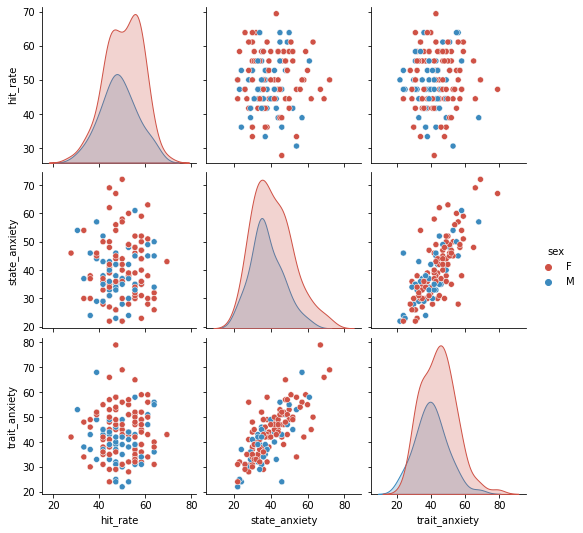

In [3]:
grid = sns.pairplot(meta[['hit_rate', 'state_anxiety', 'trait_anxiety', 'sex']],
                    hue='sex', palette=common.dark_palette)
grid.savefig("figure_2_pairplot_by_sex_color.png")


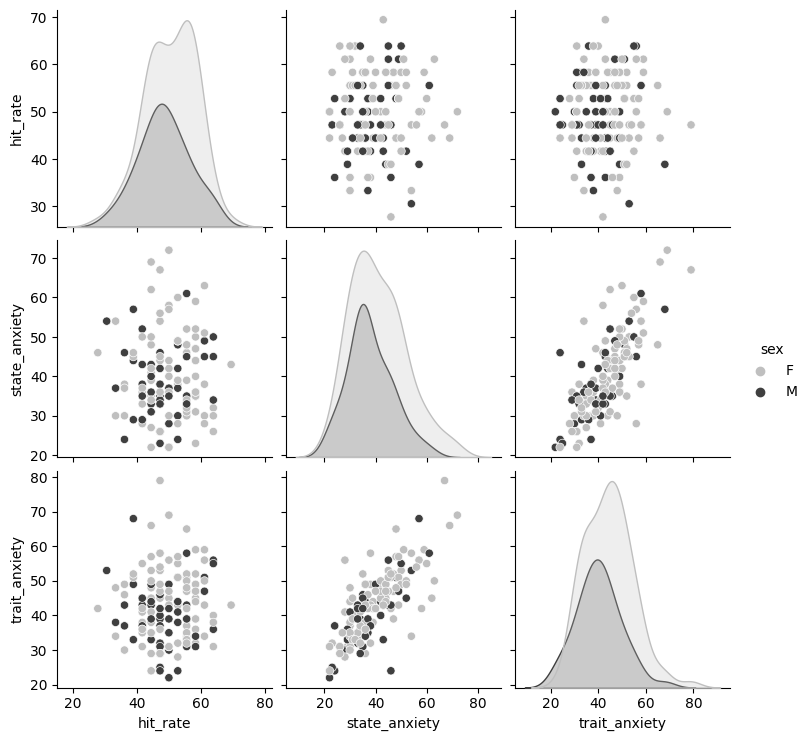

In [4]:
grid = sns.pairplot(meta[['hit_rate', 'state_anxiety', 'trait_anxiety', 'sex']],
                    hue='sex', palette=common.mid_grays_palette)
grid.savefig("figure_2_pairplot_by_sex_grayscale.png")


Note that everything looks roughly normally distributed, and random, as would be expected of repeated coin tosses. The only exception is the relationship between state_anxiety and trait_anxiety, which demonstrates a strong correlation.

## Quantify relationships

#### 3. Compare hit rates to null hypotheses

$H_{0}: {\pi} = a$ : Participants 'hit' 50%, 'miss' 50%. $H_{1}: {\pi} {\neq} a$ : Participants 'hit' more or less than 50%.

In [5]:
n = len(set(data['sheet']))
overall_hit_rate = np.mean(data['is_hit'])
overall_hit_rate_validation = np.mean(meta['hit_rate'])
overall_hit_rate_sd = np.std(meta['hit_rate'])
lo95, hi95 = stats.t.interval(
    0.95, len(data['is_hit']) - 1, loc=np.mean(data['is_hit']), scale=stats.sem(data['is_hit'])
)
t, p = stats.ttest_1samp(data['is_hit'], 0.50)
s = [
    "There are {} participants.".format(n),
    "The overall hit rate is {:0.3f} (across participants {:0.2%}, sd = {:0.4f}, 95% CI = ({:0.2%} to {:0.2%})).".format(
        overall_hit_rate, overall_hit_rate_validation / 100.0, overall_hit_rate_sd / 100.0, lo95, hi95
    ),
    "A one sample t-test assuming a 50% population average results in",
    "t of {:0.3f}, p={:0.3f}.".format(t, p),
]
if p < 0.05:
    s.append("We therefore reject the null hypothesis at the 0.05 level and report our findings.")
else:
    s.append("We cannot reject the null hypothesis; we have found no significant effect.")
print(" ".join(s))


There are 145 participants. The overall hit rate is 0.498 (across participants 49.85%, sd = 0.0791, 95% CI = (48.49% to 51.20%)). A one sample t-test assuming a 50% population average results in t of -0.221, p=0.825. We cannot reject the null hypothesis; we have found no significant effect.


$H_{0}$: Males and females hit rates are the same. $H_{1}$: they differ.

In [6]:
# Report sex-specific hit rates and t-test results.
sub_data = {}
sub_hit_rates = {}
sub_hit_sds = {}
s = []
for sex in ['male', 'female', ]:
    sub_data[sex] = data[data['sex'] == sex[0].upper()]
    n = len(set(sub_data[sex]['sheet']))
    sub_hit_rates[sex] = np.mean(sub_data[sex]['is_hit'])
    sub_hit_sds[sex] = np.std(meta[meta['sex'] == sex[0].upper()]['hit_rate']) / 100.0
    lo95, hi95 = stats.t.interval(
        0.95, len(sub_data[sex]['is_hit']) - 1, loc=np.mean(sub_data[sex]['is_hit']), scale=stats.sem(sub_data[sex]['is_hit'])
    )
    t, p = stats.ttest_1samp(sub_data[sex]['is_hit'], 0.50)
    s.append("There are {} {}s.".format(n, sex))
    s.append("The {} hit rate is {:0.3f} (sd = {:0.4f}, 95% CI = ({:0.2%} to {:0.2%})).".format(
        sex, sub_hit_rates[sex], sub_hit_sds[sex], lo95, hi95
    ))
    s.append("A one sample t-test assuming a 50% population average results in")
    s.append("t of {:0.3f}, p={:0.3f}.".format(t, p))

# Compare the sexes with a two-independent-sample t-test
t, p = stats.ttest_ind(sub_data['male']['is_hit'], sub_data['female']['is_hit'])
s.append("These differ by {:0.3f} percentage points; t={:0.3f}; p={:0.3f}.".format(
    100.0 * abs(sub_hit_rates['male'] - sub_hit_rates['female']), t, p
))
if p < 0.05:
    s.append("We therefore reject the null hypothesis at the 0.05 level and report a sex difference.")
else:
    s.append("We cannot reject the null hypothesis; we have found no significant sex difference.")

print(" ".join(s))

There are 50 males. The male hit rate is 0.486 (sd = 0.0780, 95% CI = (46.24% to 50.87%)). A one sample t-test assuming a 50% population average results in t of -1.226, p=0.220. There are 92 females. The female hit rate is 0.505 (sd = 0.0793, 95% CI = (48.84% to 52.25%)). A one sample t-test assuming a 50% population average results in t of 0.625, p=0.532. These differ by 1.988 percentage points; t=-1.358; p=0.175. We cannot reject the null hypothesis; we have found no significant sex difference.


#### 4. Box plot male-vs-female across scores

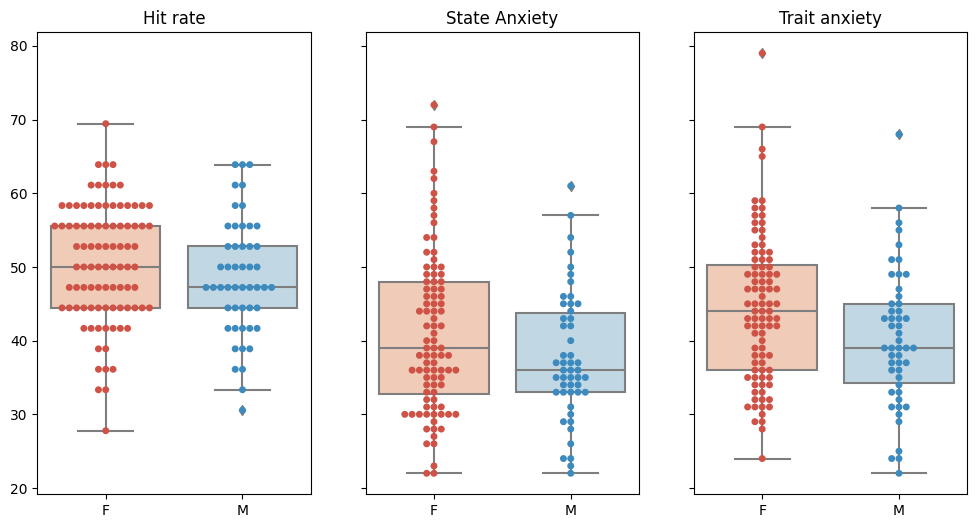

In [7]:
# And plot all three measures by sex
fig_boxes, (ab1, ab2, ab3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
sns.boxplot(x='sex', y='hit_rate', data=meta, palette=common.light_palette, ax=ab1)
sns.swarmplot(x='sex', y='hit_rate', data=meta, palette=common.dark_palette, ax=ab1)
ab1.set(ylabel="", xlabel="", title="Hit rate")
sns.boxplot(x='sex', y='state_anxiety', data=meta, palette=common.light_palette, ax=ab2)
sns.swarmplot(x='sex', y='state_anxiety', data=meta, palette=common.dark_palette, ax=ab2)
ab2.set(ylabel="", xlabel="", title="State Anxiety")
sns.boxplot(x='sex', y='trait_anxiety', data=meta, palette=common.light_palette, ax=ab3)
sns.swarmplot(x='sex', y='trait_anxiety', data=meta, palette=common.dark_palette, ax=ab3)
ab3.set(ylabel="", xlabel="", title="Trait anxiety")
fig_boxes.savefig("figure_1_vars_by_sex_boxplots_color.png")


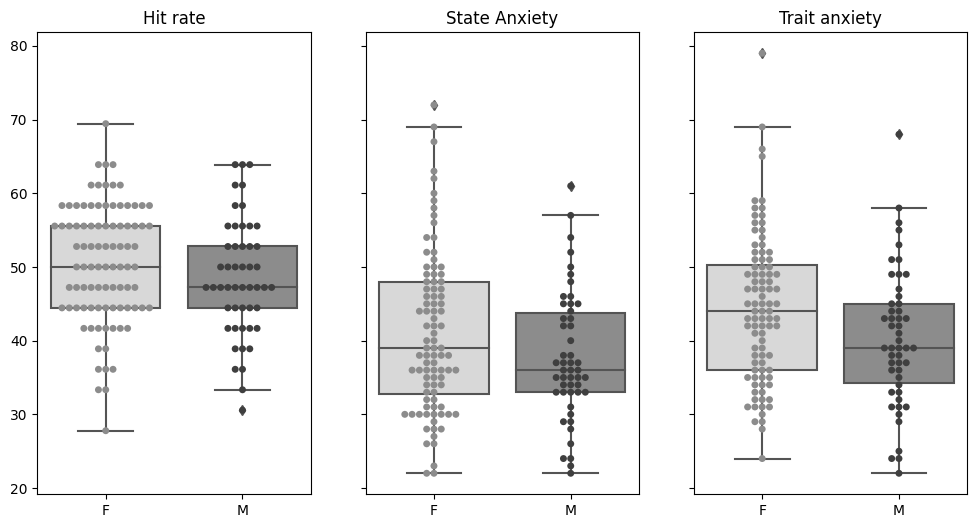

In [8]:
# And plot all three measures by sex
light_palette = sns.color_palette("light:black", as_cmap=True)

fig_boxes, (ab1, ab2, ab3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
sns.boxplot(x='sex', y='hit_rate', data=meta, palette=common.light_grays_palette, ax=ab1)
sns.swarmplot(x='sex', y='hit_rate', data=meta, palette=common.dark_grays_palette, ax=ab1)
ab1.set(ylabel="", xlabel="", title="Hit rate")
sns.boxplot(x='sex', y='state_anxiety', data=meta, palette=common.light_grays_palette, ax=ab2)
sns.swarmplot(x='sex', y='state_anxiety', data=meta, palette=common.dark_grays_palette, ax=ab2)
ab2.set(ylabel="", xlabel="", title="State Anxiety")
sns.boxplot(x='sex', y='trait_anxiety', data=meta, palette=common.light_grays_palette, ax=ab3)
sns.swarmplot(x='sex', y='trait_anxiety', data=meta, palette=common.dark_grays_palette, ax=ab3)
ab3.set(ylabel="", xlabel="", title="Trait anxiety")
fig_boxes.savefig("figure_1_vars_by_sex_boxplots_grayscale.png")


#### 5. Correlate hit rates with anxiety scores

Is either anxiety measure related to hit rate?

In [9]:
s = []
for measure in ['state_anxiety', 'trait_anxiety']:
    pr, pp = stats.pearsonr(meta['py_hit_rate'], meta[measure])
    s.append("The Pearson correlation between hit rate and {} is r={:0.3f} (p={:0.3f});".format(
        measure.replace('_', ' '), pr, pp
    ))
    sr, sp = stats.spearmanr(meta['py_hit_rate'], meta[measure])
    s.append("the Spearman correlation is r={:0.3f} (p={:0.3f}).".format(sr, sp))

print(" ".join(s))

The Pearson correlation between hit rate and state anxiety is r=0.011 (p=0.893); the Spearman correlation is r=0.029 (p=0.732). The Pearson correlation between hit rate and trait anxiety is r=0.040 (p=0.636); the Spearman correlation is r=0.057 (p=0.493).


Are anxiety measures related to hit rate in one sex or another?

In [10]:
# Report sex-specific hit rates and t-test results.
sub_meta = {}
sub_hit_rates = {}
s = []
for sex in ['male', 'female', ]:
    sub_meta[sex] = meta[meta['sex'] == sex[0].upper()]
    for measure in ['state_anxiety', 'trait_anxiety']:
        pr, pp = stats.pearsonr(sub_meta[sex]['py_hit_rate'], sub_meta[sex][measure])
        s.append("The {} Pearson correlation between hit rate and {} is r={:0.3f} (p={:0.3f})".format(
            sex, measure.replace('_', ' '), pr, pp
        ))
        sr, sp = stats.spearmanr(sub_meta[sex]['py_hit_rate'], sub_meta[sex][measure])
        s.append("the Spearman correlation is r={:0.3f} (p={:0.3f}).".format(sr, sp))

print(" ".join(s))

The male Pearson correlation between hit rate and state anxiety is r=0.034 (p=0.812) the Spearman correlation is r=0.025 (p=0.862). The male Pearson correlation between hit rate and trait anxiety is r=0.008 (p=0.958) the Spearman correlation is r=-0.009 (p=0.951). The female Pearson correlation between hit rate and state anxiety is r=-0.022 (p=0.838) the Spearman correlation is r=-0.004 (p=0.969). The female Pearson correlation between hit rate and trait anxiety is r=0.010 (p=0.926) the Spearman correlation is r=0.022 (p=0.838).


Are the anxiety measures related to each other?

In [11]:
s = []
sub_meta = {}
sub_hit_rates = {}
anxiety_pr, anxiety_pp = stats.pearsonr(meta['trait_anxiety'], meta['state_anxiety'])
anxiety_sr, anxiety_sp = stats.spearmanr(meta['trait_anxiety'], meta['state_anxiety'])
s.append("The Pearson correlation between state and trait anxiety is r={:0.3} (p={:0.3}).".format(
    anxiety_pr, anxiety_pp
))
s.append("The Spearman correlation is r={:0.3} (p={:0.3}).".format(
    anxiety_sr, anxiety_sp
))

for sex in ['male', 'female', ]:
    sub_meta[sex] = meta[meta['sex'] == sex[0].upper()]
    pr, pp = stats.pearsonr(sub_meta[sex]['trait_anxiety'], sub_meta[sex]['state_anxiety'])
    s.append("The {} Pearson correlation is r={:0.3f} (p={:0.3})".format(
        sex, pr, pp
    ))
    sr, sp = stats.spearmanr(sub_meta[sex]['trait_anxiety'], sub_meta[sex]['state_anxiety'])
    s.append("the {} Spearman correlation is r={:0.3f} (p={:0.3}).".format(sex, sr, sp))
    
print(" ".join(s))

The Pearson correlation between state and trait anxiety is r=0.768 (p=1.82e-29). The Spearman correlation is r=0.731 (p=1.6e-25). The male Pearson correlation is r=0.740 (p=8.32e-10) the male Spearman correlation is r=0.663 (p=1.52e-07). The female Pearson correlation is r=0.751 (p=6.77e-18) the female Spearman correlation is r=0.733 (p=9.94e-17).


#### 6. Scatter plot correlations, colored by sex

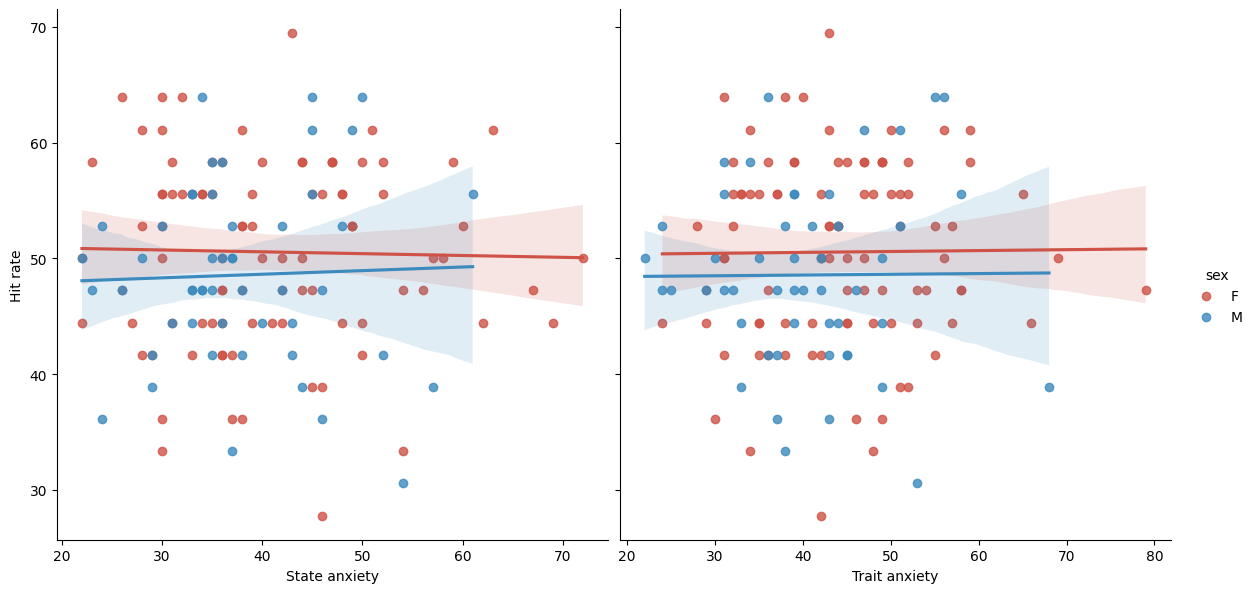

In [12]:
fig_scatters = sns.pairplot(x_vars=['state_anxiety', 'trait_anxiety'], y_vars=['hit_rate', ],
                            data=meta, hue='sex', kind='reg',
                            palette=common.dark_palette, height=6, aspect=1.0)
fig_scatters.set(ylabel="Hit rate")
fig_scatters.axes[0, 0].set(xlabel="State anxiety")
fig_scatters.axes[0, 1].set(xlabel="Trait anxiety")
fig_scatters.savefig("hit_vs_anxiety_scatter.png")

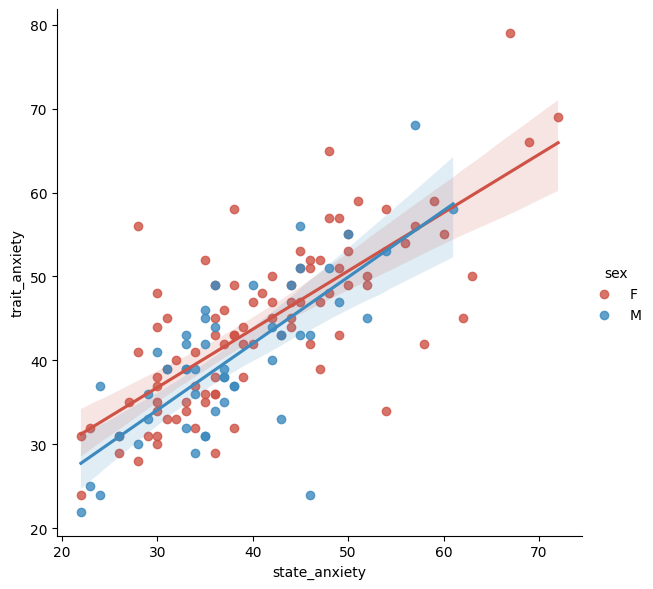

In [13]:
# Just to visualize the correlation, look at anxiety types' linear relationships.
fig_anxiety = sns.lmplot(x='state_anxiety', y='trait_anxiety', data=meta, 
                         hue='sex', palette=common.dark_palette, height=6, aspect=1.0)
fig_scatters.savefig("anxiety_types.png")